## TF tensor input model flavors with MLflow Generic Model

In [1]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.17.0


In [2]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("test_new")

<Experiment: artifact_location='mlflow-artifacts:/907121710094613815', creation_time=1730914281381, experiment_id='907121710094613815', last_update_time=1730914281381, lifecycle_stage='active', name='test_new', tags={}>

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


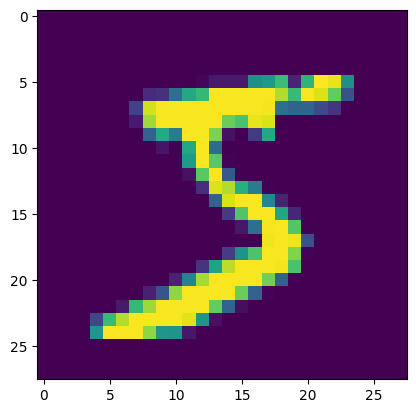

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [5]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):
        tf_model,eval_loss,eval_acc = self.train_model()
        self.tf_model = tf_model

    def predict(self, context, model_input):
        return self.tf_model.predict(model_input)
    

    def train_model(self,p_epoch=2, p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        model.fit(x_train,y_train,epochs = p_epoch)

        eval_loss, eval_acc = model.evaluate(x_test,y_test,verbose=2)


        print(f"eval_loss : {eval_loss} | eval_acc : {eval_acc}")

        return model,eval_loss,eval_acc
        




In [6]:
config_path = "data_tf.json"
params_ = {
    "epochs" : 5
}
custom_tf_obj = custom_tf_model(params_)
custom_tf_obj.load_context(config_path=config_path)
custom_tf_obj.fit(x_train=x_train,y_train=y_train)

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.7819 - loss: 0.7169
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.9148 - loss: 0.2907
313/313 - 0s - 413us/step - accuracy: 0.9516 - loss: 0.1685
eval_loss : 0.16848136484622955 | eval_acc : 0.9516000151634216


In [7]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.12.7',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.17.0']}],
 'name': 'tf_env'}

In [8]:
predictions_tf = custom_tf_obj.predict(context=None,model_input=x_test)
print(predictions_tf.shape)
model_signature = infer_signature(x_test,predictions_tf)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
(10000, 10)


In [9]:
type(model_signature)
model_signature

inputs: 
  [Tensor('float64', (-1, 28, 28))]
outputs: 
  [Tensor('float32', (-1, 10))]
params: 
  None

In [10]:
artifacts_tf = {
    "config_path" : config_path
}
artifacts_tf

{'config_path': 'data_tf.json'}

In [11]:
with mlflow.start_run(run_name="generic_model3") as run2:
    mlflow.pyfunc.log_model(
        "custom_tf",
        python_model = custom_tf_obj,
        artifacts = artifacts_tf,
        conda_env = conda_env_tf,
        signature = model_signature,
        input_example = x_train[0]
    )

2024/11/06 18:29:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update

In [12]:
import mlflow
logged_model = 'runs:/ffd4e453ce084ed1827f014bd2e45b9a/custom_tf'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [13]:
# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [14]:
result

array([[ -3.4426537 ,  -3.06995   ,   0.2740355 ,   2.6607463 ,
         -6.3128624 ,  -4.584505  , -10.84436   ,  10.368501  ,
         -2.5545783 ,  -0.11114074],
       [  0.46572363,  -4.5337477 ,   9.314175  ,   2.7545025 ,
        -13.770365  ,  -0.02056783,   0.8810861 ,  -9.267005  ,
          1.4868357 , -14.073222  ],
       [ -5.9646482 ,   5.4954066 ,   0.04175703,  -1.2263393 ,
         -3.6333065 ,  -2.9939466 ,  -2.4284549 ,   0.08449449,
         -0.18725787,  -3.4375913 ],
       [  9.61409   , -10.465796  ,  -1.49919   ,  -2.4098573 ,
         -6.679862  ,   2.2902415 ,   0.59040356,  -0.28892523,
         -2.884301  ,   0.3558315 ],
       [ -3.2562015 ,  -6.6417375 ,  -1.0696703 ,  -3.5255597 ,
          5.2593346 ,  -3.8275075 ,  -0.7683228 ,  -0.8596637 ,
         -1.3757745 ,   2.1302857 ],
       [ -7.4357805 ,   6.481259  ,  -0.45360005,  -1.2074666 ,
         -4.7650337 ,  -4.4144344 ,  -4.7796364 ,   0.8320346 ,
         -0.09582964,  -3.1041229 ],
       [ -